Prima di ogni cosa importiamo la cartella di Google drive contenente i dati che ci serviranno per i nostri esercizi:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os

# Elenca i file nella cartella specificata
data_dir = '/content/drive/Shareddrives/data_lab/'
os.listdir(data_dir)


['logo_ct.jpg',
 'logo_ct1.jpg',
 'oact_halph_fi_20240510_080000.fts',
 'hmi_202308_13392',
 '20240503',
 'data.fits']

Immaginiamo di avere acquisito un'immagine del disco solare nella riga Halpha attraverso il telescopio solare di Catania e di volerne leggere il contenuto nelle due parti che la compongono: l'header e l'array

Vediamo prima quali sono le dimensioni dell'array delle nostre immagini

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog
import tkinter as tk

# Specifica il percorso del file FITS
file_input_fits = data_dir+"oact_halph_fi_20240510_080000.fts"

# Apri il file FITS
hdul = fits.open(file_input_fits)
print(hdul[0].shape)


# Chiudi il file FITS
hdul.close()

(2048, 2048)


Vediamo quali sono alcune delle keywords più importanti riportate nell'header:

In [ ]:
print(hdul[0].header)

SIMPLE  =                    T /image conforms to FITS standard                 BITPIX  =                  -32 /bits per data value                             NAXIS   =                    2 /number of axes                                  NAXIS1  =                 2048 /                                                NAXIS2  =                 2048 /                                                EXTEND  =                    T /file may contain extensions                     FILENAME= 'oact_halph_fi_20240510_080015.fits' /                                DATE    = '2024-05-10T08:00:33' / Date of file creation                         DATE-OBS= '2024-05-10T08:00:15' / Date of observation                           DATE-BEG= '2024-05-10T08:00:15' / Date of observation                           TIMESYS = 'UTC     '           / System used for Time                           OBSVTRY = 'Catania Astrophysical Observatory' /                                 TELESCOP= 'INAF-OACt Solar Telescope' / 

Adesso visualizziamo l'immagine vera e propria:


(2048, 2048)


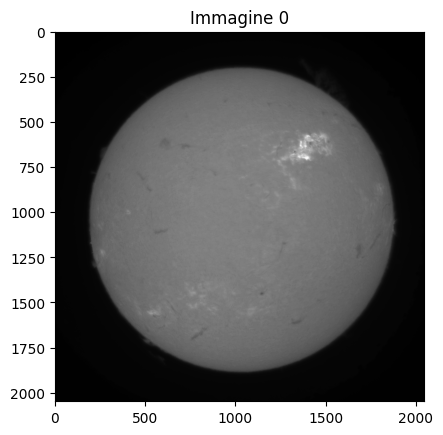

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog
import tkinter as tk

# Specifica il percorso del file FITS
file_input_fits = data_dir+"oact_halph_fi_20240510_080000.fts"

# Apri il file FITS
hdul = fits.open(file_input_fits)

try:
    # Itera attraverso le immagini nel file FITS
    for i, hdu in enumerate(hdul):


        # Estrai dati
        data = hdu.data
        print(data.shape)


        # Visualizza l'immagine
        plt.imshow(data, cmap='gray')
        plt.title(f"Immagine {i}")
        plt.show()

finally:
    # Chiudi il file FITS
    hdul.close()

Come vediamo, l'immagine non appare orientata correttamente. La AR che vediamo in alto a destra, in realtà dovrebbe trovarsi in basso a destra...

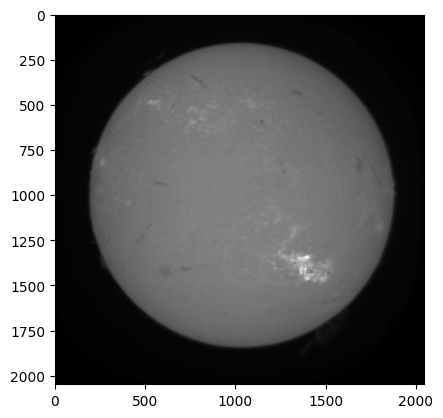

In [ ]:
flipped_ud = np.flipud(data)
plt.imshow(flipped_ud, cmap='gray')


Il nostro telescopio acquisisce di default un'immagine ogni minuto.A partire da questi dati possiamo provare a ricostruire delle curve di luce per capire come varia l'emissione in Halpha durante un flare.Quello che segue è un esempio di programma per plottare una curva di luce partendo da una lista di immagini in Halpha acquisite dal Telescopio Solare dell'OACT:


20240503,2024-05-03 08:38:00
20240503,2024-05-03 08:36:00
20240503,2024-05-03 08:36:27
20240503,2024-05-03 08:42:00
20240503,2024-05-03 08:39:47
20240503,2024-05-03 08:40:27
20240503,2024-05-03 08:43:10
20240503,2024-05-03 08:34:48
20240503,2024-05-03 08:41:00
20240503,2024-05-03 08:34:00
20240503,2024-05-03 08:41:29
20240503,2024-05-03 08:37:00
20240503,2024-05-03 08:40:00
20240503,2024-05-03 08:39:28
20240503,2024-05-03 08:44:29
20240503,2024-05-03 08:35:47
20240503,2024-05-03 08:37:27
20240503,2024-05-03 08:34:27
20240503,2024-05-03 08:43:50
20240503,2024-05-03 08:38:28
20240503,2024-05-03 08:42:30
20240503,2024-05-03 08:35:00
20240503,2024-05-03 08:43:29
20240503,2024-05-03 08:41:50
20240503,2024-05-03 08:40:48
20240503,2024-05-03 08:37:48
20240503,2024-05-03 08:42:49
20240503,2024-05-03 08:39:00
20240503,2024-05-03 08:35:28
20240503,2024-05-03 08:44:00
20240503,2024-05-03 08:36:47
20240503,2024-05-03 08:33:00
20240503,2024-05-03 08:38:47
20240503,2024-05-03 08:33:48
20240503,2024-

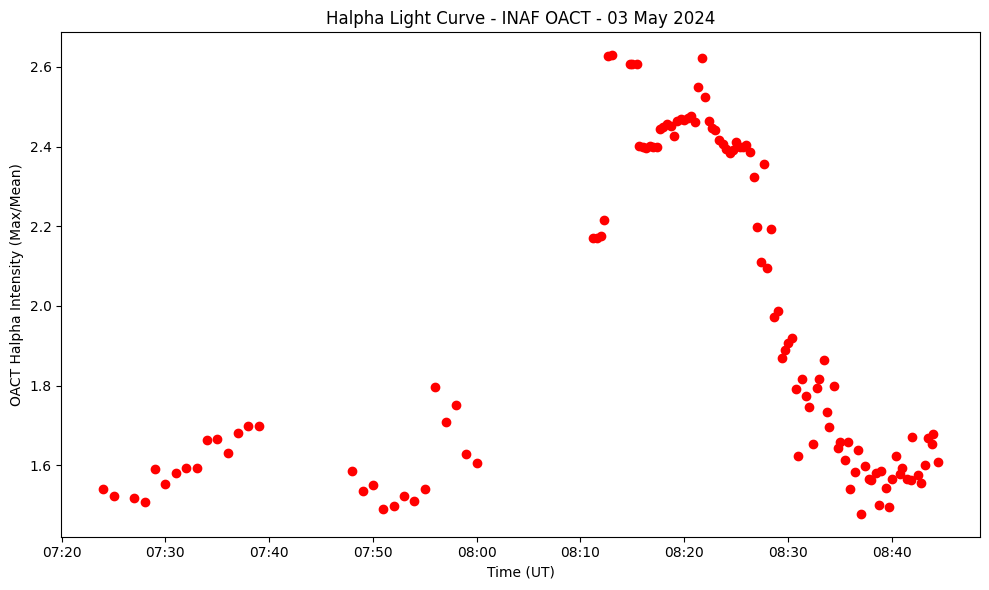

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from datetime import datetime
import matplotlib.dates as mdates
import time

# Funzione per calcolare l'intensità totale all'interno di un cerchio
def calcola_intensita_cerchio(image, center, radius, exp_time):
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    dist = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = dist <= radius

    # Calcola la media all'interno del cerchio
    average = np.mean(image[mask]) / exp_time

    # Calcola il massimo all'interno del cerchio
    top = np.max(image[mask]) / exp_time

    # Calcola l'integrale all'interno del cerchio
    integral = np.sum(image[mask]) / exp_time

    return average, top, integral

# Cartella dei file .fits
cartella_fits = data_dir+"20240503/"

# Directory e file di output
file_output = f"Flux_{os.path.basename(cartella_fits)}.txt"

dati_output = []

with open(file_output, 'w') as f_out:
    # Scrivi l'header del file di output
    f_out.write("Tempo\tAverage\tTop\tIntegral\n")

    for file_name in os.listdir(cartella_fits):
        if file_name.endswith(".fts"):
            file_path = os.path.join(cartella_fits, file_name)

            # Leggi il file .fits
            with fits.open(file_path) as hdul:
                header = hdul[0].header
                data = hdul[0].data
                exp_time = header['EXP_TIME']  # Estrai il tempo di esposizione

                # Estrai centro e raggio dall'header
                center_x = header['CENTER_X']
                center_y = header['CENTER_Y']
                radius = header['SOLAR_R']

                # Controllo se il raggio è maggiore o uguale a 800
                if radius < 800:
                    continue

                # Plot dell'immagine con la circonferenza del cerchio
                #plt.figure()
                #plt.imshow(data, cmap='gray')
                #circle = Circle((center_x, center_y), radius, edgecolor='r', facecolor='none')
                #plt.gca().add_patch(circle)
                #plt.title(file_name)
                #plt.show(block=False)  # Non bloccare l'esecuzione per chiudere automaticamente la finestra
                #plt.pause(1)  # Pausa di 2 secondi
                #plt.close()  # Chiudi la finestra

                # Calcola le grandezze
                average, top, integral = calcola_intensita_cerchio(data, (center_x, center_y), radius, exp_time)

                # Estrai il tempo dal nome del file
                file_basename = os.path.splitext(file_name)[0]
                date_str = file_basename.split('_')[3] + file_basename.split('_')[4]
                tempo = datetime.strptime(date_str, "%Y%m%d%H%M%S")
                data_titolo = tempo.strftime("%d %B %Y")
                dat=tempo.strftime("%Y%m%d")
                print(f"{dat},{tempo}" )

                # Aggiungi i dati alla lista per l'output
                dati_output.append([tempo.strftime('%H:%M:%S'), average, top, integral])

# Scrittura del file di output con le colonne spaziate bene
with open(file_output, 'w') as f_out:
    # Scrivi l'header del file di output
    f_out.write("Time\t\tMean\t\tMax\t\tIntegral\n")
    for row in dati_output:
        f_out.write(f"{row[0]}\t{row[1]:.6f}\t{row[2]:.6f}\t{row[3]:.6f}\n")

tempi = []
integrale = []
top = []
average = []

with open(file_output, 'r') as f_in:
    next(f_in)  # Salta l'header
    for line in f_in:
        tempo, avg, top_value, integral = line.strip().split("\t")
        tempi.append(datetime.strptime(tempo, "%H:%M:%S"))
        integrale.append(float(integral))
        top.append(float(top_value))
        average.append(float(avg))

# Creazione dei grafici
plt.figure(figsize=(10, 6))

# Grafico dell'integrale rispetto al tempo
#plt.subplot(2, 1, 1)
#plt.plot(tempi, [i/100 for i in integrale], marker='o', color='blue')
#plt.xlabel('Time (UT)')
#plt.ylabel('OACT Halpha Intensity (Integral)')
#plt.title(f'Halpha Light Curve - INAF OACT - {data_titolo}')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))  # Formattazione dell'asse x


# Grafico di max/mean rispetto al tempo
ratio = [top[i]/average[i] for i in range(len(integrale))]
plt.scatter(tempi, ratio, marker='o', color='red')
plt.xlabel('Time (UT)')
plt.ylabel('OACT Halpha Intensity (Max/Mean)')
plt.title(f'Halpha Light Curve - INAF OACT - {data_titolo}')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


plt.tight_layout()  # Aggiusta il layout per evitare sovrapposizioni
# Salva il grafico con il nome specificato
plt.savefig(f'OACT_lc_{dat}.jpg')

plt.show()


Putroppo, come vediamo, questo flare non è stato osservato durante la sua fase flash, ma solo durante la fase principale.

Il ruolo del campo magnetico è fondamentale per lo studio delle AR solari e dei processi che hanno luogo in esse. Adesso, quindi, vediamo un programma per accostare le informazioni sul campo magnetico fotosferico ad un'immagine delle fotosfera o della cromosfera.
Utilizziamo per questo scopo un magnetogramma acquisita da HMI, un telescopio a bordo del satellite SDO. Il programma che segue, a partire dalla data di acquisizione, è capace di scaricare un magnetogramma dello stesso giorno e ora della nostra immagine OACT. Per capire la configurazione magnetica possiamo sovrapporre i contours dei valori di campo magnetico positivo e negativo alla  nostra immagine.


Data estratta: 2024-05-10 080000
File scaricato con successo: hmi.M_720s.20240510_080000_TAI.fits
Valori header letti: X_center=1032.51869277, Y_center=1044.11114599, RADIUS=842.876
Angolo P0: -22.0499849226
offset: 1227 1228
File 'data.fits' salvato con successo.
ris_d: 1.1311
dim: (2048, 2048)
ris_h: 2.0161736
dim: (1024, 1024)
fattore_scala: 1.7824892582441871
ok
Dimensioni dell'array image_hmi: (1024, 1024)
Massimo valore nell'array image_hmi: 1831.2
Minimo valore nell'array image_hmi: -1723.3000000000002
max: 1831.2 1464.96 915.6 549.36
min: -1723.3000000000002 -1378.6400000000003 C -516.99 
dscal: 1148 1148
hmi: 1024 1024


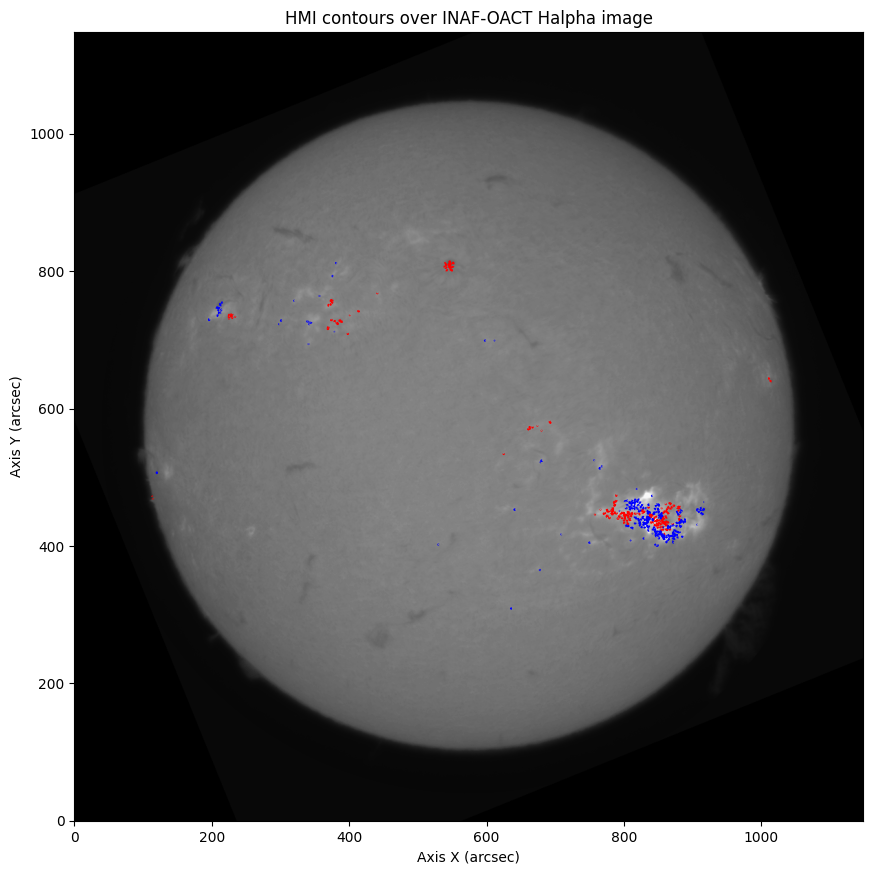

Errore nella lettura dei valori di risoluzione e dimensioni delle immagini: cannot open resource


In [ ]:
import os
import re
import requests
from astropy.io import fits
import numpy as np
from scipy.ndimage import rotate
from PIL import Image, ImageDraw
import numpy as npimport
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import measure
from PIL import Image, ImageDraw, ImageFont

def visualizza_immagine(image_data):
    # Visualizza l'immagine
    plt.imshow(image_data, cmap='gray')
    plt.colorbar(label='Intensità')
    plt.title('Immagine FITS Ruotata')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.show()

def extract_date_and_time_from_filename(filename):
    #Estrae il giorno, mese, anno e orario dal nome del file
    match = re.search(r'(\d{4})(\d{2})(\d{2})_(\d{6})', filename)
    if match:
        year, month, day, time = match.groups()
        return year, month, day, time
    else:
        raise ValueError("Il nome del file non contiene una data e un orario validi.")

def download_fits_file(year, month, day, time):
    #Scarica un file FITS dal sito specificato utilizzando la data e l'orario.
    url = f"http://jsoc.stanford.edu/data/hmi/fits/{year}/{month}/{day}/hmi.M_720s.{year}{month}{day}_{time}_TAI.fits"
    response = requests.get(url)

    if response.status_code == 200:
        file_name = f"hmi.M_720s.{year}{month}{day}_{time}_TAI.fits"
        with open(file_name, 'wb') as f:
            f.write(response.content)
        print(f"File scaricato con successo: {file_name}")
        return file_name
    else:
        print(f"Errore nel download del file: {response.status_code}")
        return None

def leggi_valori_header(file_fits):
    with fits.open(file_fits) as hdul:
        header = hdul[0].header
        center_x = header['center_x']
        center_y = header['center_y']
        solar_r = header['solar_r']
    return center_x, center_y, solar_r

def ruota_immagine(data, angolo_gradi):
    # Ruota l'immagine utilizzando la rotazione affine
    # La modalità 'nearest' mantiene i valori dei pixel più vicini dopo la rotazione
    data_ruotato = rotate(data, angolo_gradi)
    return data_ruotato

def main():
    # Definisci la cartella di input e il nome del file FITS
    cartella_input_output = data_dir
    file = data_dir+"oact_halph_fi_20240510_080000.fts"  # Cambia con il nome del tuo file FITS

    # Estrai la data e l'orario dal nome del file FITS
    try:
        year, month, day, time = extract_date_and_time_from_filename(file)
        print(f"Data estratta: {year}-{month}-{day} {time}")
    except ValueError as e:
        print(e)
        return

    # Scarica il file FITS
    file_fits = download_fits_file(year, month, day, time)
    if not file_fits:
        return

    # Leggi i valori di X_center, Y_center e RADIUS dall'header FITS
    try:
        center_x, center_y, solar_r = leggi_valori_header(os.path.join(cartella_input_output, file))
        print(f"Valori header letti: X_center={center_x}, Y_center={center_y}, RADIUS={solar_r}")
    except Exception as e:
        print(f"Errore nella lettura dell'header FITS: {e}")
        return

    # Apre il file FITS originale
    with fits.open(os.path.join(cartella_input_output, file)) as hdul:
        # Leggi l'header del file FITS
        header = hdul[0].header
        image_data1 = hdul[0].data
        base_name = os.path.splitext(file)[0]

        # Leggi l'angolo P0 dall'header FITS
        angolo_P0 = header['SOLAR_P0']
        print(f"Angolo P0: {angolo_P0}")

        image_d = image_data1

        # Calcola le coordinate per la regione di interesse
        x_min = int(center_x - (solar_r + 100))
        x_max = int(center_x + (solar_r + 100))
        y_min = int(center_y - (solar_r + 100))
        y_max = int(center_y + (solar_r + 100))

        # Definisci il centro e il raggio del cerchio bianco
        centro_cerchio_x = center_x
        centro_cerchio_y = center_y
        raggio_cerchio = solar_r + 110

        image_data=image_d

        # Estrai il valore del pixel vicino al bordo del cerchio dall'immagine FITS originale
        pixel_value_bordo = int(image_data[y_min + 10, int(center_x)]) + 100

        # Crea un'immagine nera con le stesse dimensioni
        black_image = np.full_like(image_data, pixel_value_bordo)

        # Disegna un cerchio bianco con il centro e il raggio specificati
        white_circle = Image.new('L', (image_data.shape[1], image_data.shape[0]), 0)
        draw = ImageDraw.Draw(white_circle)
        draw.ellipse((centro_cerchio_x - raggio_cerchio, centro_cerchio_y - raggio_cerchio,
                      centro_cerchio_x + raggio_cerchio, centro_cerchio_y + raggio_cerchio),
                     fill=255)

        white_circle = np.array(white_circle)

        # Combina l'immagine FITS originale con l'immagine nera usando l'operazione di mascheramento
        masked_image = np.where(white_circle == 255, image_data, black_image)

        # Estrae la regione di interesse dall'immagine FITS originale
        regione_interesse = masked_image[y_min:y_max, x_min:x_max]

        # Ruota l'immagine in base all'angolo P0
        image_data_ruotata = ruota_immagine(regione_interesse, angolo_P0)

        # Crea un array 2048x2048 con l'immagine ruotata centrata
         # Calcola gli offset per centrare l'immagine ruotata all'interno dell'array 2048x2048
        offset_x = (image_data_ruotata.shape[0]) // 2
        offset_y = (image_data_ruotata.shape[1]) // 2
        print(f"offset: {offset_x} {offset_y}")


        # Crea un array 2048x2048 e copia l'immagine ruotata al centro
        image_data_centrata = np.zeros((2048, 2048), dtype=np.float32)
        image_data_centrata= image_data_ruotata[offset_x-1024:offset_x+1024,
                         offset_y-1024:offset_y+1024]


        # Salva l'array 2048x2048 come data.fits nella cartella di output
        fits.writeto(os.path.join(cartella_input_output, 'data.fits'), image_data_centrata,
                     header=header, overwrite=True)
        print("File 'data.fits' salvato con successo.")


        # Visualizza l'immagine FITS ruotata
        #visualizza_immagine(image_data_centrata)
        cartella_hmi= '/content'
        # Trova il file hmi.M.* nella cartella
        hmi_file = None
        for filename in os.listdir(cartella_hmi):
            if filename.startswith("hmi.M") and filename.endswith(".fits"):
                hmi_file = filename
                break

        if hmi_file is None:
            print("Nessun file hmi.M* trovato nella cartella.")
            return


         # Leggi i valori di risoluzione da data.fits e hmi.M.* e calcola le dimensioni delle immagini
        try:
            # Leggi risoluzione e dimensioni da data.fits
            with fits.open(os.path.join(cartella_input_output, 'data.fits')) as hdul_data:
                hdr_d = hdul_data[0].header
                cdelt1_data = hdr_d['cdelt1']
                dimensioni_data = hdul_data[0].data.shape
                print(f"ris_d: {cdelt1_data}")
                print(f"dim: {dimensioni_data}")

                # Leggi risoluzione e dimensioni da hmi.M.*
                with fits.open(os.path.join(cartella_hmi, hmi_file)) as hdul_hmi:
                    # Seleziona l'HDU appropriato
                    header_hmi = hdul_hmi[1].header

                    # Leggi i valori di risoluzione e dimensioni dall'header dell'HDU appropriato
                    cdelt1_hmi = header_hmi['CDELT1']
                    image_hmi = hdul_hmi['COMPRESSED_IMAGE'].data
                    dimensioni_hmi = hdul_hmi['COMPRESSED_IMAGE'].data.shape
                    print(f"ris_h: {cdelt1_hmi}")
                    print(f"dim: {dimensioni_hmi}")

                    # Calcola il fattore di scala per riscalande l'immagine più grande
                    fattore_scala = cdelt1_data / cdelt1_hmi if cdelt1_data > cdelt1_hmi else cdelt1_hmi / cdelt1_data
                    print(f"fattore_scala: {fattore_scala}")

                    # Riscala l'immagine più grande
                    if cdelt1_data > cdelt1_hmi:
                    # Riscalare hmi.M.* a dimensioni_data
                        image_hmi = resize(image_hmi, (int(dimensioni_hmi[0] * fattore_scala), int(dimensioni_hmi[1] * fattore_scala)))
                        data_scaled = image_hmi
                    else:
                    # Riscalare data.fits a dimensioni_hmi
                        data_scaled = resize(hdul_data[0].data, (int(dimensioni_data[0] / fattore_scala), int(dimensioni_data[1] / fattore_scala)))
                        print(f"ok")

                        # Visualizza le dimensioni dell'array
                    print("Dimensioni dell'array image_hmi:", image_hmi.shape)

                    # Calcola il massimo e il minimo dell'array
                    print("Massimo valore nell'array image_hmi:", np.nanmax(image_hmi))
                    print("Minimo valore nell'array image_hmi:", np.nanmin(image_hmi))


                    # Calcola i contorni per l'immagine hmi
                    max_val = np.nanmax(image_hmi)
                    min_val = np.nanmin(image_hmi)
                    level_80p_max = max_val * 0.8
                    level_50p_max = max_val * 0.5
                    level_30p_max = max_val * 0.3
                    print(f"max: {max_val} {level_80p_max} {level_50p_max} {level_30p_max}")
                    level_80p_min = min_val * 0.8
                    level_50p_min = min_val * 0.5
                    level_30p_min = min_val * 0.3
                    print(f"min: {min_val} {level_80p_min} C {level_30p_min} ")

                    # Trova i contorni per i livelli positivi
                    contours_max = measure.find_contours(image_hmi, max_val)
                    contours_80p_max = measure.find_contours(image_hmi, level_80p_max)
                    contours_50p_max = measure.find_contours(image_hmi, level_50p_max)
                    contours_30p_max = measure.find_contours(image_hmi, level_30p_max)

                    # Trova i contorni per i livelli negativi
                    contours_min = measure.find_contours(image_hmi, min_val)
                    contours_80p_min = measure.find_contours(image_hmi, level_80p_min)
                    contours_50p_min = measure.find_contours(image_hmi, level_50p_min)
                    contours_30p_min = measure.find_contours(image_hmi, level_30p_min)

                    # Creazione della figura con dimensioni corrispondenti a quelle dell'immagine
                    plt.figure(figsize=(10.24, 10.24))
                    print(f"dscal: {data_scaled.shape[0]} {data_scaled.shape[1]}")
                    print(f"hmi: {image_hmi.shape[0]} {image_hmi.shape[1]}")


                    # Plotta l'immagine data riscalata
                    plt.imshow(data_scaled, cmap='gray', origin='lower', extent=[0, dimensioni_data[1]/fattore_scala, 0, dimensioni_data[0]/fattore_scala])

                    # Calcola il fattore di scala tra data_scaled e image_hmi
                    fx = (data_scaled.shape[1]-image_hmi.shape[1])/2
                    fy = (data_scaled.shape[0]-image_hmi.shape[0])/2


                    # Plotta i contorni positivi in rosso
                    for contour in contours_max:
                        plt.plot(contour[:, 1]+fx, contour[:, 0]+fy, 'r', zorder=10)

                    for contour in contours_80p_max:
                        plt.plot(contour[:, 1]+fx, contour[:, 0]+fy, 'r--', zorder=10)

                    for contour in contours_50p_max:
                        plt.plot(contour[:, 1]+fx, contour[:, 0]+fy, 'r:', zorder=10)

                    for contour in contours_30p_max:
                        plt.plot(contour[:, 1]+fx, contour[:, 0]+fy, 'r:', zorder=10)

                    # Plotta i contorni negativi in blu
                    for contour in contours_min:
                        plt.plot(contour[:, 1]+fx, contour[:, 0]+fy, 'b', zorder=10)

                    for contour in contours_80p_min:
                        plt.plot(contour[:, 1]+fx, contour[:, 0]+fy, 'b--', zorder=10)

                    for contour in contours_50p_min:
                        plt.plot(contour[:, 1]+fx, contour[:, 0]+fy, 'b:', zorder=10)

                    for contour in contours_30p_min:
                        plt.plot(contour[:, 1]+fx, contour[:, 0]+fy, 'b:', zorder=10)

                        # Imposta i limiti degli assi in base alle dimensioni dell'immagine
                    plt.xlim(0, data_scaled.shape[1])
                    plt.ylim(0, data_scaled.shape[0])


                    # Aggiungi altri dettagli al grafico, ad esempio etichette, titoli, ecc.
                    plt.title("HMI contours over INAF-OACT Halpha image")
                    plt.xlabel("Axis X (arcsec)")
                    plt.ylabel("Axis Y (arcsec)")

                    # Salva il grafico come immagine e chiudi la finestra di visualizzazione
                    plt.savefig("output_contours.png",bbox_inches='tight')
                    plt.show()
                    plt.close()

                    # Converti data_scaled in un oggetto PIL Image
                    data_scaled_pil = Image.open("output_contours.png")


                    #         PARTE PER LOGHI E SCRITTE

                     # Carica i loghi
                    logo_path1 = data_dir+"logo_ct.jpg"
                    logo_path2 = data_dir+"logo_ct1.jpg"

                    logo1 = Image.open(logo_path1)
                    logo2 = Image.open(logo_path2)

                    logo1 = logo1.resize((int(logo1.width * 0.6), int(logo1.height * 0.6)))  # Aumenta le dimensioni del 20%
                    logo2 = logo2.resize((int(logo2.width * 0.06), int(logo2.height * 0.06)))  # Aumenta le dimensioni del 20%


                    # Calcola le coordinate per posizionare i loghi
                    x_offset = 1
                    y_offset = 1

                    # Incolla il primo logo in alto a sinistra
                    data_scaled_pil.paste(logo1, (x_offset, y_offset))


                    # Incolla il testo accanto al primo logo
                    draw = ImageDraw.Draw(data_scaled_pil)
                    font = ImageFont.truetype("arial.ttf", 15)
                    #text = "Catania Astrophysical Observatory"
                    text3 = f"{year}{month}{day} {time}"
                    text_bbox = draw.textbbox((0, 0), text3, font=font)
                    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
                    draw.text((x_offset + logo1.width + 10, y_offset+10), text3, fill=(0, 0, 0), font=font)
                    #draw.text((x_offset + logo1.width + 10, y_offset+20), text3, fill=(0, 0, 0), font=font)

                    # Incolla il testo accanto al secondo logo
                    #text2 = "Halpha (656.28 nm)"
                    #text_bbox2 = draw.textbbox((0, 0), text2, font=font)
                    #text_width2, text_height2 = text_bbox2[2] - text_bbox2[0], text_bbox2[3] - text_bbox2[1]
                    #draw.text((data_scaled_pil.width - logo2.width - x_offset - text_width2 - 10, y_offset), text2, fill=(0, 0, 0), font=font)

                    # Incolla il secondo logo in alto a destra
                    data_scaled_pil.paste(logo2, (data_scaled_pil.size[0] - logo2.width - x_offset, y_offset))
                    # Converti l'immagine in RGB prima di salvarla come JPEG
                    data_rgb = data_scaled_pil.convert("RGB")
                    file_out=f"{base_name}_hmi.jpg"
                    data_rgb.save(file_out)

                    print(f"Immagine salvata in")

        except Exception as e:
            print(f"Errore nella lettura dei valori di risoluzione e dimensioni delle immagini: {e}")
            return
if __name__ == "__main__":
    main()


Infine un codice  che serve a calcolare e plottare il flusso di una regione attiva nel tempo


Aggiungendo dati per hmi.sharp_cea_720s.9875.20230802_000000_TAI.magnetogram.fits: 0, 361.1868577843019, 1777.1000000000001, -249.46086853345992, -1042.8, 4182905.0, -4204912.4
Aggiungendo dati per hmi.sharp_cea_720s.9875.20230802_020000_TAI.magnetogram.fits: 1, 358.76982268317164, 1763.4, -253.87720676421208, -1042.4, 4289452.0, -4233656.300000001
Aggiungendo dati per hmi.sharp_cea_720s.9875.20230802_040000_TAI.magnetogram.fits: 2, 367.71016892735287, 1755.7, -255.14872729410382, -1063.6000000000001, 4418773.1, -4340335.0
Aggiungendo dati per hmi.sharp_cea_720s.9875.20230802_060000_TAI.magnetogram.fits: 3, 367.2982794494239, 1795.9, -255.41187541638908, -1226.5, 4589759.300000001, -4600478.7
Aggiungendo dati per hmi.sharp_cea_720s.9875.20230802_100000_TAI.magnetogram.fits: 4, 371.744281200632, 1614.8000000000002, -263.08569516569406, -1179.8, 4706282.600000001, -4914177.699999999
Aggiungendo dati per hmi.sharp_cea_720s.9875.20230802_120000_TAI.magnetogram.fits: 5, 362.91465184133745, 

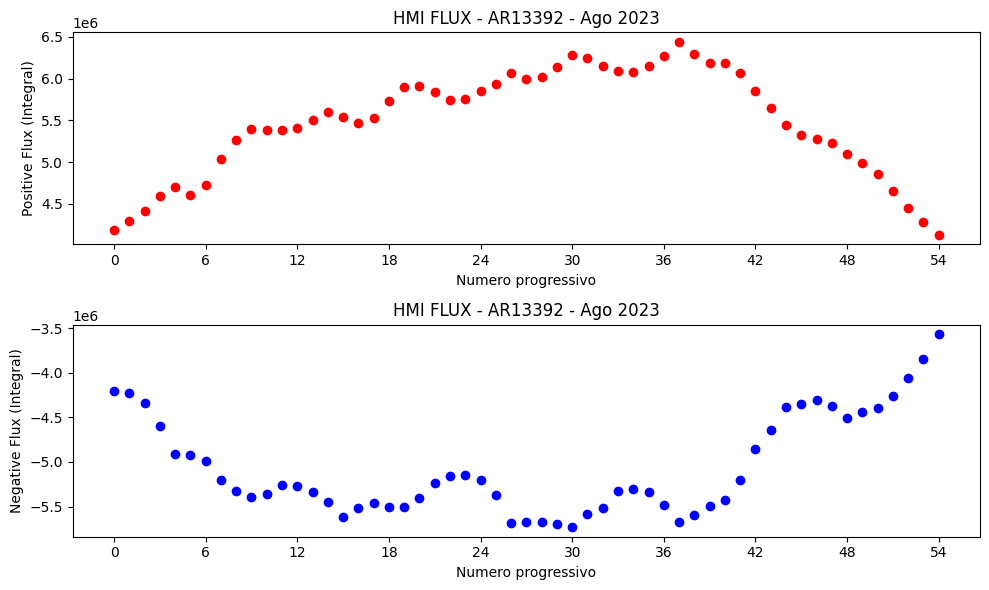

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.dates as mdates

# Funzione per calcolare il flusso positivo e negativo all'interno della regione
def calcola_intensita_magnetogramma(image):

    # Filtra i valori positivi e negativi
    pos_values = image[image > 100]
    neg_values = image[image < -100]

    # Calcola la media e il massimo dei valori positivi
    mean_p = np.mean(pos_values) if pos_values.size > 0 else 0
    max_p = np.max(pos_values) if pos_values.size > 0 else 0

    # Calcola la media e il minimo dei valori negativi
    mean_n = np.mean(neg_values) if neg_values.size > 0 else 0
    max_n = np.min(neg_values) if neg_values.size > 0 else 0

    # Calcola l'integrale del flusso positivo e negativo
    integral_p = np.sum(pos_values)
    integral_n = np.sum(neg_values)

    return mean_p, max_p, mean_n, max_n,integral_p, integral_n

# Cartella dei file .fits
cartella_input =data_dir+'/hmi_202308_13392'

# Directory e file di output
file_output = f"Flux_{os.path.basename(cartella_input)}.txt"

dati_output = []

# Ottieni i file nella cartella
file_list = [f for f in os.listdir(cartella_input) if f.startswith("hmi") and f.endswith(".fits")]

# Ordina i file
file_list.sort()

# Apri il file di output per scrivere i dati
with open(file_output, 'a') as f_out:
    f_out.write("Numero\tmean_p\tmax\tmean_n\tmin\tintegral_p\tintegral_n\n")

    # Itera su tutti i file nella cartella di input
    for idx, file_name in enumerate(file_list):
        file_path = os.path.join(cartella_input, file_name)

        try:
            # Leggi il file FITS
            with fits.open(file_path) as hdul_hmi:
                data = hdul_hmi[1].data  # HDU index 1 spesso contiene i dati principali

                # Calcola le grandezze
                mean_p, max_p, mean_n, max_n, integral_p, integral_n = calcola_intensita_magnetogramma(data)

                # Aggiungi i dati alla lista per l'output
                print(f"Aggiungendo dati per {file_name}: {idx}, {mean_p}, {max_p}, {mean_n}, {max_n}, {integral_p}, {integral_n}")
                dati_output.append([idx, mean_p, max_p, mean_n, max_n, integral_p, integral_n])
        except Exception as e:
            print(f"Errore durante l'elaborazione del file {file_name}: {e}")

# Scrittura del file di output con le colonne spaziate bene
with open(file_output, 'w') as f_out:
    # Scrivi dati nel file di output
    f_out.write("Numero\tmean_p\tmax\tmean_n\tmin\tintegral_p\tintegral_n\n")
    for row in dati_output:
        f_out.write(f"{row[0]}\t{row[1]:.8f}\t{row[2]:.8f}\t{row[3]:.8f}\t{row[4]:.8f}\t{row[5]:.8f}\t{row[6]:.8f}\n")

numeri = []
mean_p_list = []
max_p_list = []
mean_n_list = []
max_n_list = []
int_n_list = []
int_p_list = []
# Lettura dei dati dal file di output
with open(file_output, 'r') as f_in:
    next(f_in)  # Salta l'header
    for line in f_in:
        numero, mean_p, max_p, mean_n, max_n, integral_p, integral_n= line.strip().split("\t")
        numeri.append(int(numero))
        mean_p_list.append(float(mean_p))
        max_p_list.append(float(max_p))
        int_p_list.append(float(integral_p))
        mean_n_list.append(float(mean_n))
        max_n_list.append(float(max_n))
        int_n_list.append(float(integral_n))

# Creazione dei grafici
plt.figure(figsize=(10, 6))

# Grafico flusso positivo rispetto al numero progressivo
plt.subplot(2, 1, 1)
plt.scatter(numeri, int_p_list, marker='o', color='red')
plt.xticks(np.arange(0, len(numeri), 6))  # Imposta i tick sull'asse x con intervalli di 6
plt.xlabel('Numero progressivo')
plt.ylabel('Positive Flux (Integral)')
plt.title(f'HMI FLUX - AR13392 - Ago 2023')

# Grafico flusso negativo rispetto al numero progressivo
plt.subplot(2, 1, 2)
plt.scatter(numeri, int_n_list, marker='o', color='blue')
plt.xticks(np.arange(0, len(numeri), 6))  # Imposta i tick sull'asse x con intervalli di 6
plt.xlabel('Numero progressivo')
plt.ylabel('Negative Flux (Integral)')
plt.title(f'HMI FLUX - AR13392 - Ago 2023')

plt.tight_layout()  # Aggiusta il layout per evitare sovrapposizioni
plt.savefig(f'HMI_flux_integral_AR13392.jpg')  # Salva il grafico
plt.show()
